In [51]:
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df = pd.read_csv('data/df_out.csv')

print(f'Размерность датафрейма: {df.shape}')

df.head()

Размерность датафрейма: (10000, 20)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


# Data Preparation

## Data Exploration

In [3]:
# Находим количество дубликатов в датафрейме

num_duplicates = df.duplicated().sum()

print(f'Количество дубликатов: {num_duplicates}')

Количество дубликатов: 0


In [4]:
# Выводим текущие типы данных всех столбцов, чтобы проверить, какие из них нужно преобразовать

df.dtypes

id                  int64
url                object
region             object
region_url         object
price               int64
year              float64
manufacturer       object
model              object
fuel               object
odometer            int64
title_status       object
transmission       object
image_url          object
description        object
state              object
lat               float64
long              float64
posting_date       object
price_category     object
date               object
dtype: object

In [5]:
# Считаем количество и процент пропусков по всем столбцам, формируем таблицу и выводим ее

missing_counts = df.isnull().sum()

missing_percent = (df.isnull().mean() * 100).round(2)

missing_df = pd.DataFrame({'Missing Values': missing_counts, 'Percent (%)': missing_percent})

print(f'Количество пропусков:')
missing_df

Количество пропусков:


,Missing Values,Percent (%)
id,0,0.00
url,0,0.00
region,0,0.00
region_url,0,0.00
price,0,0.00
year,36,0.36
manufacturer,0,0.00
model,128,1.28
fuel,63,0.63
odometer,0,0.00


In [6]:
# Проверяем числовые столбцы на выбросы с помощью правила межквартильного размаха 

numeric_cols = ['price', 'odometer', 'year']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f'{col}: выбросов {outliers.shape[0]} (границы: {lower_bound:.2f} - {upper_bound:.2f})')

price: выбросов 215 (границы: -22235.00 - 58125.00)
odometer: выбросов 0 (границы: -107444.38 - 283466.62)
year: выбросов 394 (границы: 1994.50 - 2030.50)


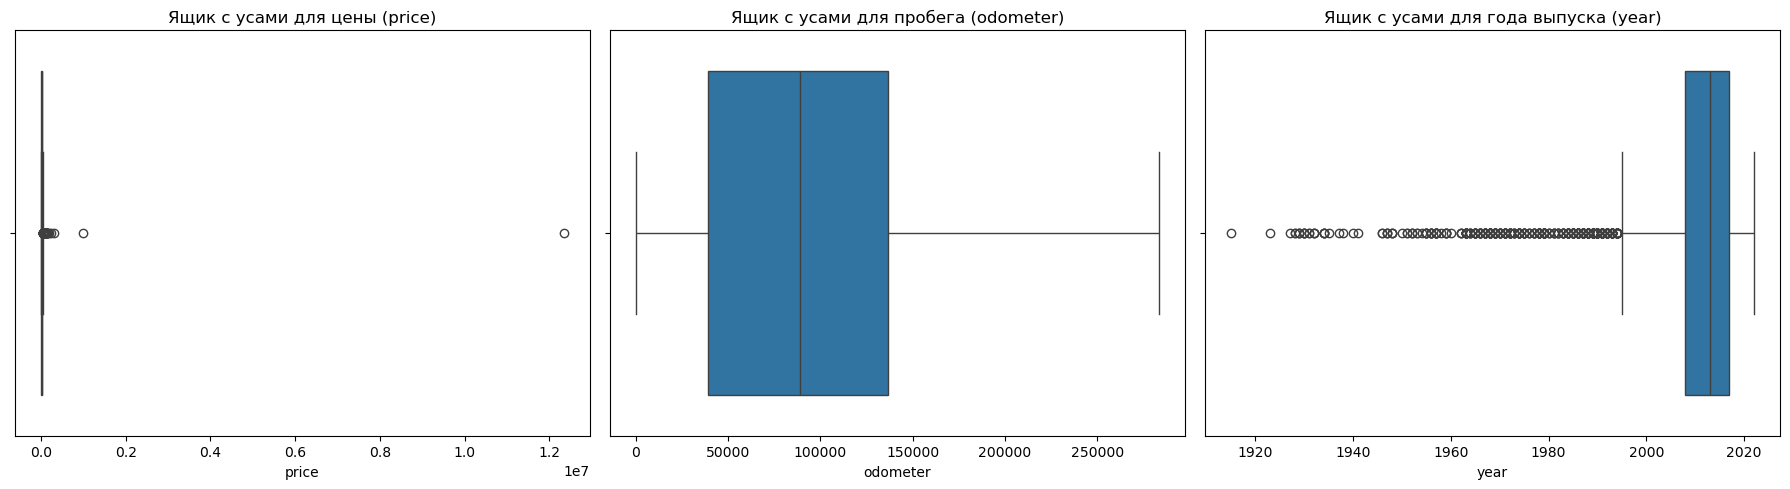

In [7]:
# Строим ящик с усами для основных числовых признаков, чтобы выявить выбросы и аномалии

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=df['price'])
plt.title('Ящик с усами для цены (price)')

plt.subplot(1, 3, 2)
sns.boxplot(x=df['odometer'])
plt.title('Ящик с усами для пробега (odometer)')

plt.subplot(1, 3, 3)
sns.boxplot(x=df['year'])
plt.title('Ящик с усами для года выпуска (year)')

plt.tight_layout()
plt.show()

## Data Cleaning

In [8]:
# Приводим типы данных к корректным форматам для дальнейшей обработки

df['posting_date'] = pd.to_datetime(df['posting_date'], utc=True)
df['date'] = pd.to_datetime(df['date'], utc=True)
df['year'] = df['year'].astype('Int64')

df.dtypes

id                              int64
url                            object
region                         object
region_url                     object
price                           int64
year                            Int64
manufacturer                   object
model                          object
fuel                           object
odometer                        int64
title_status                   object
transmission                   object
image_url                      object
description                    object
state                          object
lat                           float64
long                          float64
posting_date      datetime64[ns, UTC]
price_category                 object
date              datetime64[ns, UTC]
dtype: object

In [9]:
# Обработка пропусков: заполняем пропуски в числовых и категориальных признаках, а также удаляем записи с отсутствующими датами

# Заполняем пропуски в столбце 'year' медианным значением
df['year'] = df['year'].fillna(df['year'].median())

# Заполняем пропуски в 'model' значением 'Unknown'
df['model'] = df['model'].fillna('Unknown')

# Заполняем пропуски в 'fuel', 'title_status' и 'transmission' наиболее частыми значениями (модой)
df['fuel'] = df['fuel'].fillna(df['fuel'].mode()[0])
df['title_status'] = df['title_status'].fillna(df['title_status'].mode()[0])
df['transmission'] = df['transmission'].fillna(df['transmission'].mode()[0])

# Заполняем пропуски в 'description' пустой строкой
df['description'] = df['description'].fillna('')

# Удаляем строки с пропусками в координатах 'lat' и 'long'
df = df.dropna(subset=['lat', 'long'])

# Удаляем строки с пропусками в датах 'posting_date' и 'date'
df = df.dropna(subset=['posting_date', 'date'])

In [10]:
# Проверяем, остались ли пропуски в датафрейме после обработки

missing_counts_after = df.isnull().sum()
missing_percent_after = (df.isnull().mean() * 100).round(2)
missing_df_after = pd.DataFrame({'Missing Values': missing_counts_after, 'Percent (%)': missing_percent_after})

print('Остаток пропусков после обработки:')
print(missing_df_after)

Остаток пропусков после обработки:
                Missing Values  Percent (%)
id                           0          0.0
url                          0          0.0
region                       0          0.0
region_url                   0          0.0
price                        0          0.0
year                         0          0.0
manufacturer                 0          0.0
model                        0          0.0
fuel                         0          0.0
odometer                     0          0.0
title_status                 0          0.0
transmission                 0          0.0
image_url                    0          0.0
description                  0          0.0
state                        0          0.0
lat                          0          0.0
long                         0          0.0
posting_date                 0          0.0
price_category               0          0.0
date                         0          0.0


In [11]:
# Коррекция выбросов в цене: вычисляем границы по IQR с учётом, что цена не может быть ниже нуля, и заменяем значения за пределами этих границ на соответствующие граничные значения

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

df['price'] = df['price'].clip(lower=lower_bound, upper=upper_bound)

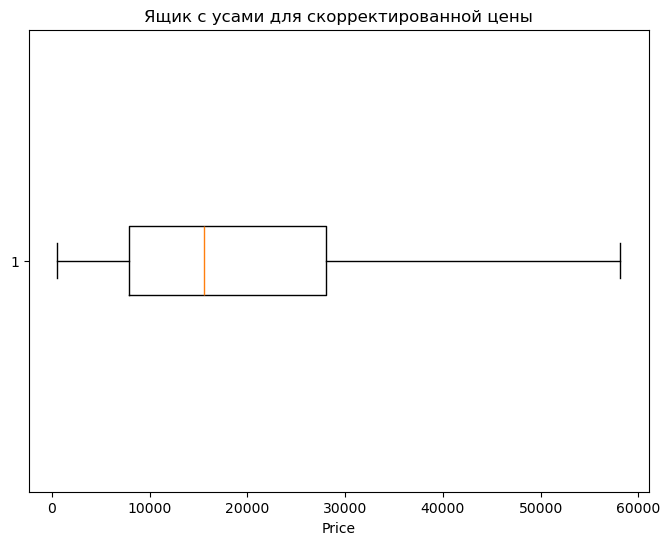

In [12]:
# Построение ящика с усами для столбца 'price' после коррекции выбросов

plt.figure(figsize=(8, 6))
plt.boxplot(df['price'], vert=False)
plt.title('Ящик с усами для скорректированной цены')
plt.xlabel('Price')
plt.show()

# Feature engineering

## Categorical Encoding

In [13]:
# Преобразуем категориальные признаки в one-hot кодировку

categorical_cols = ['region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'state']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

df_cat_ohe = pd.DataFrame(ohe.fit_transform(df[categorical_cols]),
                          columns=ohe.get_feature_names_out(categorical_cols),
                          index=df.index)

## Feature Scaling

In [14]:
# Стандартизация/нормализация числовых признаков

numeric_cols = ['price', 'year', 'odometer', 'lat', 'long']
scaler = StandardScaler()
df_num_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_cols]),
                             columns=numeric_cols,
                             index=df.index)

## Feature Creation

In [15]:
# Создаем новые признаки на основе даты публикации и размещения

df['posting_year'] = df['posting_date'].dt.year
df['posting_month'] = df['posting_date'].dt.month
df['posting_dayofweek'] = df['posting_date'].dt.dayofweek

df['days_since_posting'] = (df['date'] - df['posting_date']).dt.days

In [16]:
# Удаляем исходные колонки с датами, которые теперь не нужны

df = df.drop(columns=['posting_date', 'date', 'url', 'region_url', 'image_url', 'description', 'id'])

## Final Dataset Preparation

In [22]:
# Объединяем числовые и категориальные признаки в финальный датасет

df_final = pd.concat([df_num_scaled, df_cat_ohe, df[['posting_year', 'posting_month', 'posting_dayofweek', 'days_since_posting']]], axis=1)

df_final['price_category'] = df['price_category']

In [23]:
df_final.head()

,price,year,odometer,lat,long,region_SF bay area,region_abilene,region_akron / canton,region_albany,region_albuquerque,...,state_vt,state_wa,state_wi,state_wv,state_wy,posting_year,posting_month,posting_dayofweek,days_since_posting,price_category
0,2.624587,0.937410,-1.041359,-0.604685,0.491840,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2021,4,5,0,high
1,-0.146810,0.524595,-0.526809,0.381149,1.109023,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2021,5,0,0,medium
2,1.211501,0.627799,-1.252890,-0.823825,0.538079,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2021,4,2,0,high
3,-0.324684,0.214985,0.377623,-0.492453,0.855634,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2021,4,5,0,medium
4,0.207045,1.040613,-1.348406,0.352575,1.133972,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2021,5,0,0,medium


In [24]:
# Сохраняем финальный датасет для моделирования

df_final.to_csv('df_final_for_modeling.csv', index=False)

# Modelling

## Prepare Dataset for Training

In [38]:
# Выбираем признаки (X) и целевую переменную (y)

X = df_final.drop(columns=['price_category'])  
y = df_final['price_category']

## Split Data into Training and Testing Sets

In [39]:
# Делим данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Initialize Models

In [40]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(random_state=42)
mlp = MLPClassifier(max_iter=1000, random_state=42)

## Hyperparameter Tuning 

In [41]:
# Определяем сетку параметров для подбора случайного леса

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Настраиваем GridSearchCV с 5-кратной кросс-валидацией
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

print("Запускаем подбор гиперпараметров для случайного леса...")
grid_rf.fit(X_train, y_train)

print("Лучшие параметры для случайного леса:", grid_rf.best_params_)

Запускаем подбор гиперпараметров для случайного леса...
Лучшие параметры для случайного леса: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


## Train Models and Compare on Training Set

In [42]:
# Обучаем логистическую регрессию и МЛП на тренировочных данных

logreg.fit(X_train, y_train)
mlp.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

print(f"Точность логистической регрессии на тренировке: {logreg.score(X_train, y_train):.3f}")
print(f"Точность МЛП на тренировке: {mlp.score(X_train, y_train):.3f}")
print(f"Точность случайного леса (лучшая) на тренировке: {best_rf.score(X_train, y_train):.3f}")

C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Точность логистической регрессии на тренировке: 0.995
Точность МЛП на тренировке: 0.992
Точность случайного леса (лучшая) на тренировке: 1.000


## Evaluate Best Model on Test Set

In [49]:
# Делаем предсказания на тесте лучшей моделью случайного леса и выводим точность 

y_pred = best_rf.predict(X_test)

print("Точность на тестовой выборке:", accuracy_score(y_test, y_pred))

Точность на тестовой выборке: 0.9959616355376073


# Results

Судя по результатам, случайный лес показал наилучшую точность на тестовой выборке (0.996). У модели нет признаков переобучения: точность на тренировочной выборке совпадает с тестовой. Вывод: случайный лес - лучшая модель, её и будем сохранять как итоговую.

In [50]:
# Сохраняем модель в файл

with open('best_model_random_forest.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

print("Модель успешно сохранена в файл 'best_model_random_forest.pkl'")

Модель успешно сохранена в файл 'best_model_random_forest.pkl'
